## PREDICTOR THE STOCK PRICES OF A COMPANY, USING THE LONG SHORT-TERM MEMORY (LSTM) MODEL.

Importe las bibliotecas necesarias como NumPy, pandas, yfinance y matplotlib.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout, LSTM

### RECOPILANDO INFORMACIÓN
 Establezca las fechas de inicio y finalización para recuperar los datos bursátiles. Después descargue los datos de acciones para la empresa y el rango de fechas especificados usando `yfinance.download()`.

In [ ]:
ori_star= dt.datetime(2020,1,1)
company="DIS"
ori_end =dt.datetime(2023,1,1)
data = yf.download(company,start=ori_star,end=ori_end)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,145.289993,148.199997,145.100006,148.199997,148.199997,9502100
2020-01-03,146.399994,147.899994,146.050003,146.500000,146.500000,7320200
2020-01-06,145.539993,146.029999,144.309998,145.649994,145.649994,8262500
2020-01-07,145.990005,146.869995,145.419998,145.699997,145.699997,6906500
2020-01-08,145.490005,146.130005,144.820007,145.399994,145.399994,6984200
...,...,...,...,...,...,...
2022-12-23,86.059998,88.070000,85.769997,88.010002,88.010002,11171600
2022-12-27,87.419998,87.940002,85.959999,86.370003,86.370003,11561400
2022-12-28,86.080002,86.690002,84.070000,84.169998,84.169998,12399500


### PREPARANDO DATOS
Iniciamos con un escalamiento de datos entre 0 y 1 para normalizar los precios de cierre, además se elige el número de días utilizados para predecir el siguiente precio

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1,1))  #Seleccionamos los valores del precio de cierre.

prediction_days =  60  # El número de dias que queremos ocupar del pasado para predecir el siguiente precio de cierre.

Creación de conjuntos de entrenamiento `(x_train, y_train)` utilizando datos escalados

In [ ]:
x_train =[]    #Creamos listas para almacenar los datos de entrenamiento
y_train = []

#Con un ciclo llenaremos las listas anteriores
for i in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[i-prediction_days:i,0])
    y_train.append(scaled_data[i,0])

x_train=np.array(x_train)
y_train=np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) # Redimensionamiento de x_train para que sea compatible con la entrada de LSTM

## CREACION DEL MODELO
Primero vamos a crear un red neuronal basica con `Sequential()` y crando Redes Neuronales Recurrentes, o bien las llamadas `Long-Short Term Memory(LSTM)` son una extensión de las redes neuronales recurrentes, que básicamente amplían su memoria para aprender de experiencias importantes que han pasado hace mucho tiempo. Las LSTM permiten a las RNN recordar sus entradas durante un largo período de tiempo.

1. **Creación del Modelo Secuencial:**
Se inicia creando un modelo secuencial en Keras, lo que permite construir la red neuronal capa por capa de manera secuencial.

2. **Añadir Capas LSTM:**
Se añaden tres capas LSTM, cada una con 50 unidades. La primera capa tiene la configuración `return_sequences=True`, indicando que devuelve secuencias. Esto es crucial para conectar múltiples capas LSTM.

3. **Añadir Capas de Dropout:**
Entre las capas LSTM, se insertan capas de Dropout con una tasa del 20%. Estas capas ayudan a prevenir el sobreajuste apagando aleatoriamente un 20% de las neuronas durante el entrenamiento.

4. **Añadir Capa Densa de Salida:**
Se añade una capa densa (totalmente conectada) con 1 unidad, que es la salida para la predicción del precio de cierre del siguiente día.

5. **Compilación del Modelo:**
Se compila el modelo utilizando el optimizador "adam" y la función de pérdida "mean_squared_error". Adam es un algoritmo de optimización popular para entrenar redes neuronales.

6. **Entrenamiento del Modelo:**
El modelo se entrena con los datos de entrenamiento (x_train y y_train) durante 25 épocas, utilizando un tamaño de lote de 32. Durante el entrenamiento, la red aprende a predecir los precios de cierre de acciones basándose en las secuencias temporales proporcionadas.

In [ ]:
# Creación de un modelo secuencial
model = Sequential()

# Agrega una capa LSTM con 50 unidades, devolviendo secuencias y especificando la forma de entrada
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Agrega una capa de Dropout para regularización
model.add(Dropout(0.2))

# Agrega otra capa LSTM con 50 unidades y devolviendo secuencias
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Agrega una capa densa (totalmente conectada) con 1 unidad, que es la salida para la predicción del precio de cierre del siguiente día
model.add(Dense(units=1)) #Esta es la predicción del precio de cierre del siguiente día.

# Compilación del modelo con el optimizador "adam" y la función de pérdida "mean_squared_error"
model.compile(optimizer="adam",loss="mean_squared_error") # Compilación del modelo

# Entrenamiento del modelo con los datos de entrenamiento (x_train, y_train)
model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
22/22 [==============================] - 15s 87ms/step - loss: 0.0586
Epoch 2/25
22/22 [==============================] - 2s 96ms/step - loss: 0.0110
Epoch 3/25
22/22 [==============================] - 2s 86ms/step - loss: 0.0073
Epoch 4/25
22/22 [==============================] - 2s 96ms/step - loss: 0.0078
Epoch 5/25
22/22 [==============================] - 2s 82ms/step - loss: 0.0066
Epoch 6/25
22/22 [==============================] - 2s 90ms/step - loss: 0.0065
Epoch 7/25
22/22 [==============================] - 2s 84ms/step - loss: 0.0072
Epoch 8/25
22/22 [==============================] - 2s 87ms/step - loss: 0.0057
Epoch 9/25
22/22 [==============================] - 2s 79ms/step - loss: 0.0060
Epoch 10/25
22/22 [==============================] - 2s 80ms/step - loss: 0.0057
Epoch 11/25
22/22 [==============================] - 2s 82ms/step - loss: 0.0055
Epoch 12/25
22/22 [==============================] - 2s 83ms/step - loss: 0.0064
Epoch 13/25
22/22 [=================

## PROBANDO LA VERICIDAD DEL MODELO CON DATOS EXISTENTES
Es decir, datemos al modelo datos pasados antes de los que ya sabemos que existen y asi veremos que tan  bueno es. Asi pues procedemos a la descarga de datos de prueba para evaluar el modelo en un período posterior

In [ ]:
test_start = dt.datetime(2023,1,1)
test_end = dt.datetime.now()
test_data = yf.download(company,start=test_start,end=test_end)
test_data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,88.980003,89.970001,87.830002,88.970001,88.970001,14997100
2023-01-04,90.000000,92.750000,89.360001,91.980003,91.980003,14957200
2023-01-05,91.660004,92.480003,90.510002,91.919998,91.919998,11622600
2023-01-06,92.660004,94.690002,91.320000,93.919998,93.919998,9828100
2023-01-09,94.430000,95.699997,93.449997,94.769997,94.769997,11675800
...,...,...,...,...,...,...
2023-11-17,94.750000,95.379997,93.919998,94.150002,94.150002,12189300
2023-11-20,93.980003,95.589996,93.870003,95.029999,95.029999,14105300
2023-11-21,94.730003,94.959999,93.959999,94.449997,94.449997,7654800


Preparación de datos de prueba para la predicción

In [ ]:
actual_prices =test_data["Close"].values

total_dataset = pd.concat((data["Close"],test_data["Close"]),axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

### INICIAMOS LAS PREDICCIONES DE LOS DATOS DE PRUEBA

In [ ]:
# Inicializa una lista vacía para almacenar los datos de prueba
x_test=[]

# Iteramos sobre los datos de entrada del modelo (model_inputs) para construir los conjuntos de prueba
for i in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[i-prediction_days:i,0])

# Convierte la lista de datos de prueba a un array de NumPy
x_test =np.array(x_test)

# Redimensiona el array para que sea compatible con la entrada del modelo LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Realización de predicciones utilizando el modelo entrenado
predicted_prices = model.predict(x_test)

# Invierte la escala de las predicciones para obtener los valores en la escala original
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 3s 24ms/step


### GRAFICANDO LAS PREDICCIONES

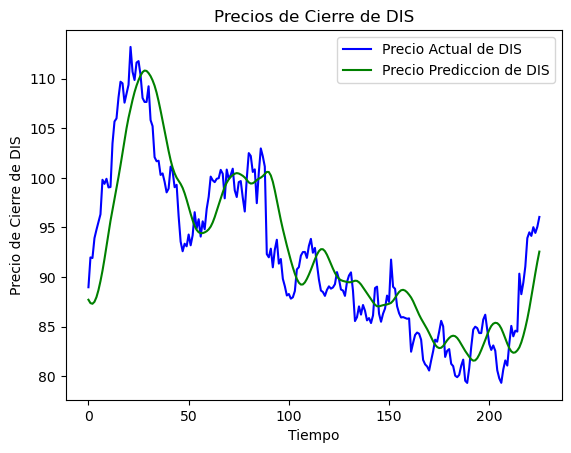

In [ ]:
plt.plot(actual_prices , color="blue",label=f"Precio Actual de {company}")
plt.plot(predicted_prices , color="green",label=f"Precio Prediccion de {company}")
plt.title(f"Precios de Cierre de {company}")
plt.xlabel("Tiempo")
plt.ylabel(f"Precio de Cierre de {company}")
plt.legend()
plt.show()

### PREDICIENDO LOS DIAS SIGUIENTES

In [ ]:
#Selecciona los datos más recientes del modelo_inputs para realizar la predicción
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]

# Convierte los datos seleccionados a un array de NumPy
real_data = np.array(real_data)

# Redimensiona el array para que sea compatible con la entrada del modelo LSTM
real_data =np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

# Realiza la predicción utilizando el modelo entrenado
prediction = model.predict(real_data)

# Invierte la escala de la predicción para obtener el valor en la escala original
prediction =scaler.inverse_transform(prediction)

# Imprime la predicción
print(f"La prediccion para el precio de cierre del dia siguiente es: ", math.trunc(float(prediction)) ," USD")


1/1 [==============================] - 0s 188ms/step
La prediccion para el precio de cierre del dia siguiente es:  93.48973846435547  USD
